In [1]:
# utilities
import re
import pickle
import numpy as np
import pandas as pandas

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
## Checking out the data set for training the model ##

df = pandas.read_csv('E:/Project 5 credits/Final Project/final_dataset.csv', encoding = "ISO-8859-1", header=None,low_memory=False)
df.head()

 # As the data has no column titles, we will add our own
df.columns = ["id", "previousindex", "label","tweet"]

df.head()

,id,previousindex,label,tweet
0,1,0.0,0,I'm exhausted from using so many Megan Thee St...
1,2,1.0,0,ranbooâ??s arg is gonna be less heavy / anxi...
2,3,2.0,0,"@ZiaMcCorgi555 Wandavision : ""Clinically depr..."
3,4,3.0,0,@ellamAYNiaa @BigDaddySamurai @shaurya__kumar ...
4,5,4.0,0,"Athe than , no time for depression all peh pun..."


In [3]:
df.columns[df.isnull().any()].tolist()

['previousindex']

In [4]:
del df["previousindex"]
df.isnull().any().any()

False

In [5]:
print(df)

            id label                                              tweet
0            1     0  I'm exhausted from using so many Megan Thee St...
1            2     0  ranbooâ??s arg is gonna be   less heavy / anxi...
2            3     0  @ZiaMcCorgi555 Wandavision :  "Clinically depr...
3            4     0  @ellamAYNiaa @BigDaddySamurai @shaurya__kumar ...
4            5     0  Athe than , no time for depression all peh pun...
...        ...   ...                                                ...
199996  199997     1  @Noufah i have tickets worth about 70 KD - abo...
199997  199998     1                 #Hoppusday so amazing!  brilliant!
199998  199999     1                   @Ramkarthik u just made that up 
199999  200000     1     @KChenoweth Cool! My cousin Kacie is in Hair. 
200000  200001     1  still hasnt slept....but has been have an inte...

[200001 rows x 3 columns]


In [6]:
df.dtypes
df.drop(100000, inplace=True)

In [7]:
df['label'] = pandas.to_numeric(df['label'])

In [8]:
df.dtypes

id        int64
label     int64
tweet    object
dtype: object

In [10]:
temp = df.groupby('label').count()['tweet'].reset_index().sort_values(by='tweet',ascending=False)
temp.style.background_gradient(cmap='Purples')

,label,tweet
0,0,100000
1,1,100000


<AxesSubplot:xlabel='label', ylabel='count'>

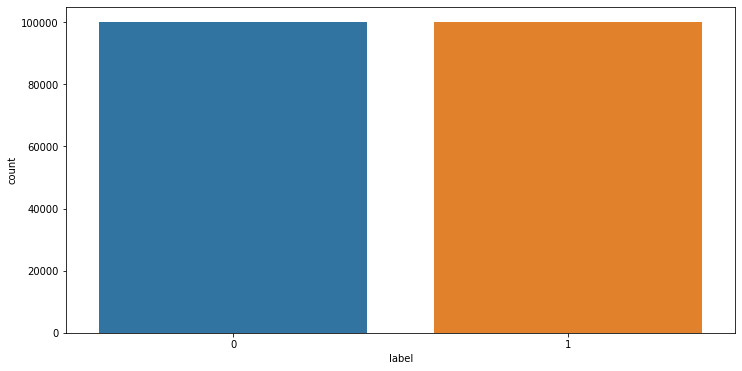

In [12]:
plt.figure(figsize=(12,6))
sns.countplot(x='label',data=df)

In [13]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## Defining set containing all stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [14]:
def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
            if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText

In [16]:
text, sentiment = list(df['tweet']), list(df['label'])

In [17]:
import time
t = time.time()
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 33 seconds


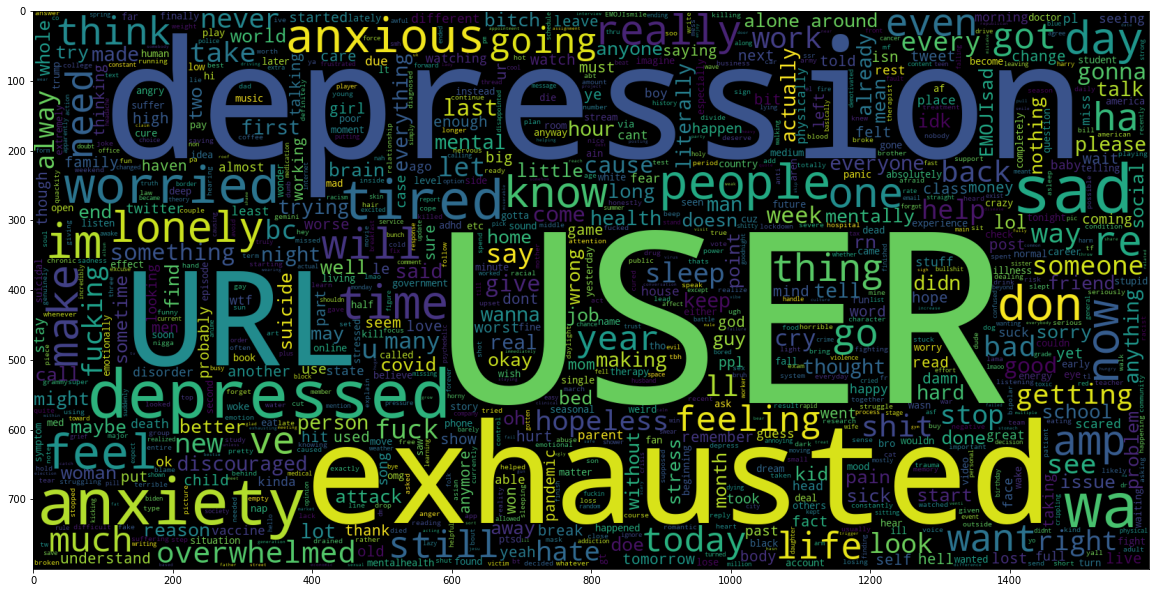

In [18]:
data_neg = processedtext[:100000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

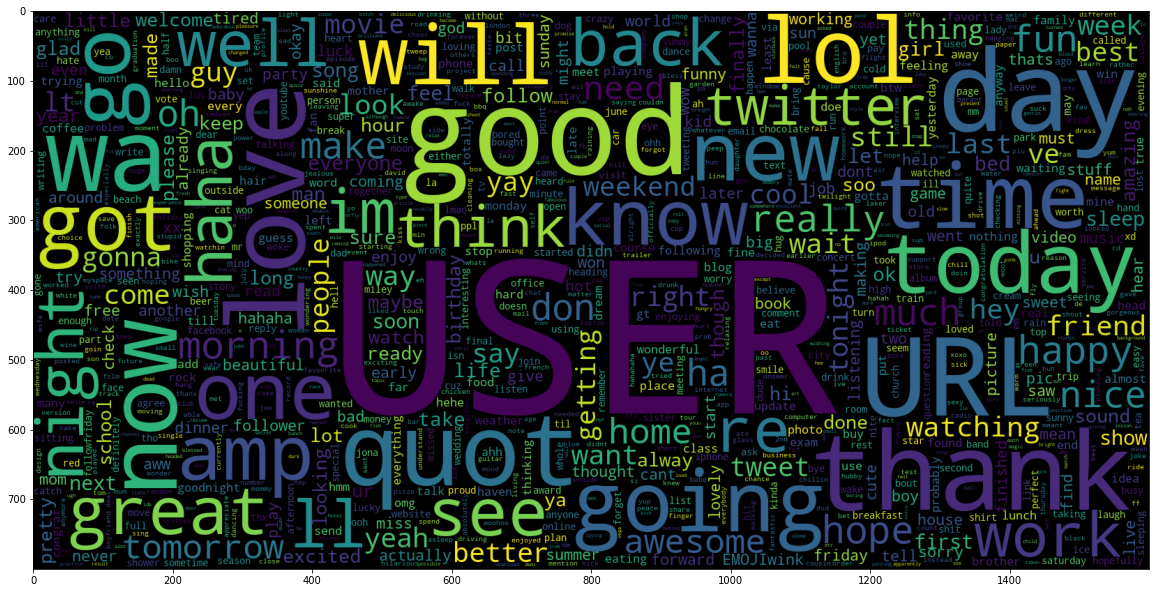

In [19]:
data_pos = processedtext[100000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment, test_size = 0.2, random_state = 0)
print(f'Data Split done.')

Data Split done.


In [21]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=100000)
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

Vectoriser fitted.
No. of feature_words:  100000


In [22]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


In [23]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['0','1']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

              precision    recall  f1-score   support

           0       0.95      0.89      0.92     19913
           1       0.90      0.95      0.93     20087

    accuracy                           0.92     40000
   macro avg       0.92      0.92      0.92     40000
weighted avg       0.92      0.92      0.92     40000



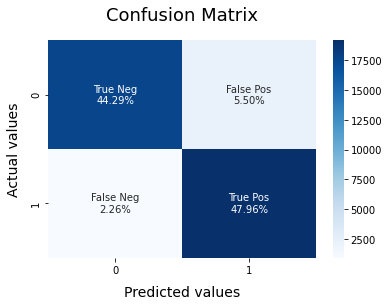

In [24]:
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)

              precision    recall  f1-score   support

           0       0.99      0.98      0.99     19913
           1       0.98      0.99      0.99     20087

    accuracy                           0.99     40000
   macro avg       0.99      0.99      0.99     40000
weighted avg       0.99      0.99      0.99     40000



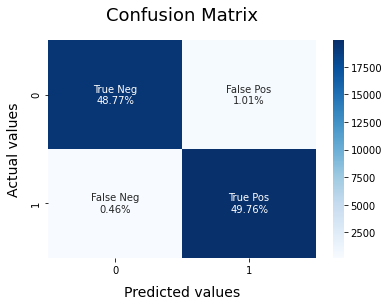

In [25]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)

              precision    recall  f1-score   support

           0       0.99      0.98      0.98     19913
           1       0.98      0.99      0.98     20087

    accuracy                           0.98     40000
   macro avg       0.98      0.98      0.98     40000
weighted avg       0.98      0.98      0.98     40000



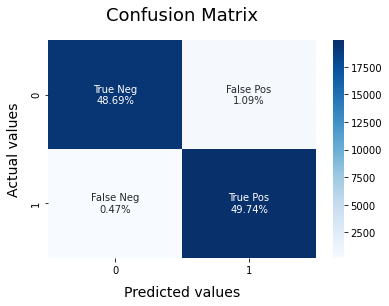

In [26]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)

In [27]:
file = open('vectoriser-ngram-(1,2).pickle','wb')
pickle.dump(vectoriser, file)
file.close()

file = open('Sentiment-LR.pickle','wb')
pickle.dump(LRmodel, file)
file.close()

file = open('Sentiment-BNB.pickle','wb')
pickle.dump(BNBmodel, file)
file.close()

In [30]:
def load_models():
    '''
    Replace '..path/' by the path of the saved models.
    '''
    
    # Load the vectoriser.
    file = open('E:/Project 5 credits/Final Project/vectoriser-ngram-(1,2).pickle', 'rb')
    
    vectoriser = pickle.load(file)
    file.close()
    # Load the LR Model.
    file = open('E:/Project 5 credits/Final Project/Sentiment-LRv1.pickle', 'rb')
    LRmodel = pickle.load(file)
    file.close()
    
    return vectoriser, LRmodel

def predict(vectoriser, model, text):
    # Predict the sentiment
    textdata = vectoriser.transform(preprocess(text))
    sentiment = model.predict(textdata)
    
    # Make a list of text with sentiment.
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text,pred))
        
    # Convert the list into a Pandas DataFrame.
    df = pandas.DataFrame(data, columns = ['text','sentiment'])
    df = df.replace([0,1], ["Depressive","Non Depressive"])
    return df

if __name__=="__main__":
    # Loading the models.
    #vectoriser, LRmodel = load_models()
    
    # Text to classify should be in a list.
    text = ["I hate twitter",
            "May the Force be with you.",
            "Mr. Stark, I don't feel so good",
            "I am exhausted"]
    
    df = predict(vectoriser, LRmodel, text)
    print(df.head())

                              text       sentiment
0                   I hate twitter  Non Depressive
1       May the Force be with you.  Non Depressive
2  Mr. Stark, I don't feel so good  Non Depressive
3                   I am exhausted      Depressive
